## Fater testing out of the panel app integrations

In [1]:
import sys
import os
import io

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import init_setup
init_setup()

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import panel as pn

from skbio.diversity import beta_diversity
from skbio.stats.ordination import pcoa

# All low level functions are imported from the momics package
from momics.loader import load_parquets
import momics.plotting as pl
# from momics.panel_utils import diversity_select_widgets, create_indicators
# from momics.utils import memory_load
from momics.diversity import (
    shannon_index,
    calculate_alpha_diversity,
    alpha_diversity_parametrized,
    beta_diversity_parametrized,
)

# Note: This is breaking the panel preview functionality
%load_ext autoreload
%autoreload 2

Platform: local Linux


In [2]:
def get_data(folder):
    return load_parquets(folder)

def fill_na_for_object_columns(df):
    """
    Fill NA values with 'NA' for object columns in the dataframe.

    Args:
        df (pd.DataFrame): The input dataframe.

    Returns:
        pd.DataFrame: The dataframe with NA values filled for object columns.
    """
    # Apply fillna only to object columns
    df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(lambda col: col.fillna('NA'))
    return df

def get_metadata(folder):
    # Load metadata
    sample_metadata = pd.read_csv(
        os.path.join(folder, "Batch1and2_combined_logsheets_2024-09-11.csv")
    )

    observatory_metadata = pd.read_csv(
        os.path.join(folder, "Observatory_combined_logsheets_validated.csv")
    )

    # Merge metadata
    full_metadata = pd.merge(
        sample_metadata,
        observatory_metadata,
        on=["obs_id", "env_package"],  # Matching conditions
        how="inner"  # Inner join
    )

    # Sort the merged dataframe by 'ref_code' column in ascending order
    full_metadata = full_metadata.sort_values(by="ref_code", ascending=True)

    # first convert some of the boolean cols
    full_metadata["failure"] = full_metadata["failure"].astype(str)
    # replace the 'nan' values with 'NA'
    full_metadata["failure"] = full_metadata["failure"].replace("nan", "NA")


    # adding replacement for the missing values for object type columns
    full_metadata = fill_na_for_object_columns(full_metadata)
    
    return full_metadata

In [3]:
# parquet files
if 'google.colab' in str(get_ipython()):
    root_folder = os.path.abspath(os.path.join('/content/momics-demos'))
else:
    root_folder = os.path.abspath(os.path.join('../'))


data_folder = os.path.join(root_folder, 'data/parquet_files')
assets_folder = os.path.join(root_folder, 'assets')


mgf_parquet_dfs = get_data(data_folder)

# metadata
# Load and merge metadata
full_metadata = get_metadata(data_folder)

# select categorical columns from metadata
categorical_columns = sorted(full_metadata.select_dtypes(include=['object', "boolean"]).columns)
cat_to_remove = ["ref_code", "samp_description", "source_mat_id", "source_mat_id_orig"]
categorical_columns = [k for k in categorical_columns if k not in cat_to_remove]

# select numerical columns from metadata
numerical_columns = sorted(full_metadata.select_dtypes(include=['int64', 'float64']).columns)

assert len(full_metadata.columns) == len(numerical_columns) + len(categorical_columns) + len(cat_to_remove)  # +1 for 'ref_code'

In [4]:
type(mgf_parquet_dfs), len(mgf_parquet_dfs), type(mgf_parquet_dfs['go'])

(dict, 7, pandas.core.frame.DataFrame)

In [5]:
# no problem here, just ADD the normalization option
beta = beta_diversity_parametrized(mgf_parquet_dfs['SSU'], 'class')
# beta.to_data_frame().columns

In [10]:
pcoa_result = pcoa(beta, method="eigh") #, number_of_dimensions=3)
pcoa_result.samples.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54
EMOBON00001,-0.264807,-0.032960,0.061166,-0.088810,0.004280,-0.118417,0.029262,-0.032240,-0.048454,-0.008452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EMOBON00084,-0.243453,-0.046238,0.048309,-0.167371,0.121040,-0.148858,0.098479,-0.104726,-0.018356,-0.045707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EMOBON00086,-0.102705,-0.048966,0.002641,0.046028,0.211569,-0.119856,-0.140285,-0.139277,-0.050580,0.037447,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EMOBON00088,-0.253481,-0.011165,-0.005298,-0.030183,-0.008775,-0.088108,-0.001221,-0.016257,-0.056592,-0.002055,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EMOBON00091,-0.275367,-0.033219,0.008284,-0.047196,0.043599,-0.055258,0.035214,-0.025480,-0.071940,0.016451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## I just need to use pcoa_results.proportion_explained

10.251691497065252

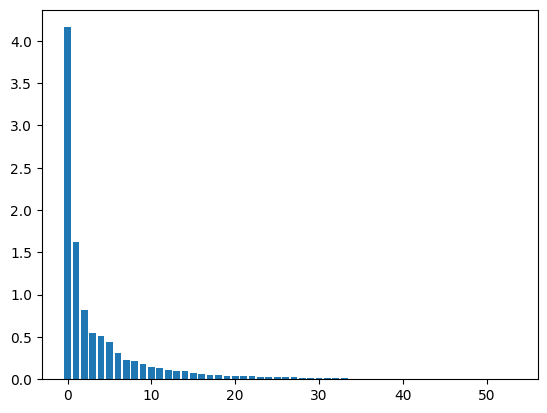

In [14]:
## test if eigen values are ordered
plt.bar(range(len(pcoa_result.eigvals)), pcoa_result.eigvals)
sum(pcoa_result.eigvals)

In [17]:
pcoa_result.proportion_explained[:2].sum() * 100

np.float64(56.41870203837217)

In [13]:
pcoa_df = pd.merge(
        pcoa_result.samples,
        full_metadata,
        left_index=True,
        right_on="ref_code",
        how="inner",
    )

In [ ]:
pcoa_df.head()

In [ ]:
pcoa_df.describe()

In [ ]:
pcoa_df['contact_name'].value_counts()

In [ ]:
for factor in categorical_columns:
    fig = pl.plot_pcoa_black(pcoa_df, color_by=factor)
    display(fig)

In [ ]:
pl.plot_pcoa_black(pcoa_df, color_by="alkalinity")
pcoa_df['alkalinity'].value_counts()

In [ ]:
full_metadata['alkalinity'].unique()

## Testing the tests

In [31]:
def sample_tables_dict():
    """Fixture that provides a dictionary of sample tables for testing."""
    data = {
        "ref_code": ["sample1", "sample2", "sample3"],
        "GO:0001": [10, 0, 5],
        "GO:0002": [20, 0, 5],
        "IPR0001": [30, 0, 5],
        "K0001": [40, 0, 5],
        "PF0001": [50, 0, 5],
        }
    return {"sample_table": pd.DataFrame(data)}


def sample_data(sample_tables_dict):
    return sample_tables_dict["sample_table"]


def sample_factors():
    """Fixture that provides sample factors for testing."""
    factors = {
        "ref_code": ["sample1", "sample2", "sample3"],
        "factor1": ["A", "B", "C"],
    }

    return pd.DataFrame(factors)


def test_calculate_alpha_diversity(sample_data, sample_factors):
    """Tests the calculate_alpha_diversity function."""
    result = calculate_alpha_diversity(sample_data, sample_factors)

    # Check if the result is a DataFrame
    assert isinstance(result, pd.DataFrame), "The result should be a DataFrame"

    # Check if the result contains the expected columns
    expected_columns = ["ref_code", "Shannon", "factor1"]
    assert all(
        col in result.columns for col in expected_columns
    ), f"Expected columns {expected_columns}, but got {result.columns.tolist()}"

    # Check if the Shannon index values are calculated correctly
    expected_shannon = sample_data.apply(lambda row: shannon_index(row[1:]), axis=1)
    expected_shannon2 = sample_data.apply(lambda row: shannon_index(row[1:]))

    display(expected_shannon, result["Shannon"], result, expected_shannon2)

    # assert all(
    #     result["Shannon"].round(3) == expected_shannon.round(3)
    # ), "The Shannon index values are not calculated correctly"

    assert np.isclose(result["Shannon"], expected_shannon).all(), (
        "The Shannon_index values are not calculated correctly, diff is " + 
        f"{(result['Shannon'] - expected_shannon).tolist()}"
    )

    # Check if the factors are merged correctly
    assert all(
        result["factor1"] == sample_factors["factor1"]
    ), "The factors are not merged correctly"

In [32]:
d= sample_tables_dict()
sample_data = sample_data(d)
sample_factors = sample_factors()

test_calculate_alpha_diversity(sample_data, sample_factors)


0    1.489750
1         NaN
2    1.609438
dtype: float64

0    1.489750
1         NaN
2    1.609438
Name: Shannon, dtype: float64

,ref_code,Shannon,factor1
0,sample1,1.489750,A
1,sample2,NaN,B
2,sample3,1.609438,C


ref_code    NaN
GO:0001     0.0
GO:0002     0.0
IPR0001     0.0
K0001       0.0
PF0001      0.0
dtype: float64

AssertionError: The Shannon_index values are not calculated correctly, diff is [0.0, nan, 0.0]